# Honest Sampling
In this notebook, I will try to implement honest sampling in sklearn's random forest and hopefully this solves the overfitting problem in our conditional entropy estimate.

## Sampling Code

In [1]:
import numpy as np

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
sns.distplot(list(zip(*class_one))[0], hist=False, rug=True)
sns.distplot(list(zip(*class_neg_one))[0], hist=False, rug=True)
plt.title("Distribution Plot with Mean = 2")
plt.show()

<Figure size 640x480 with 1 Axes>

In [3]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(1000, 1, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = None):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))

        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].item()).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
        
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 500, .33)


0.3277995562724258

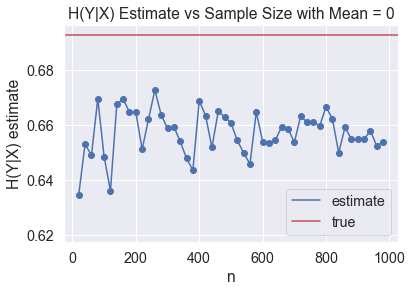

In [6]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*20 for i in range(1, 50)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 500, .32))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(0)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

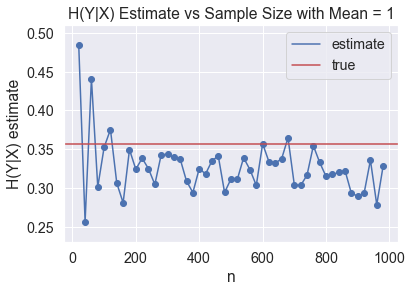

In [7]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(1)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.show()